In [376]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG

In [377]:
top_k = 50

drop_columns = [
    "device",
    "learning_rate",
    "batch_size",
    "top_k",
    "seed",
    "epochs",
    "datasets",
    "log"
]

if False:
    for k in CONFIG.top_k:
        if k != top_k:
            drop_columns.extend([f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}"])

print(drop_columns)

['device', 'learning_rate', 'batch_size', 'top_k', 'seed', 'epochs', 'datasets', 'log']


In [378]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, train_loss, *res = lines[-1].strip().split("\t")

        d = json.loads(lines[0])

        d["Epochs"] = int(epochs)
        d["Loss"] = float(train_loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i * 3:(i * 3)+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)

df

,dataset,n_layers,embedding_dim,fusion_type,fusion_modalities,autoencoder,multimodal,single_branch,freeze,ensemble_fusion,...,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50,bidirectional,early_stop_window,early_stop_threshold,alpha
2025-01-21T00:35:57,dbbook,0,256,late,mean,False,False,False,True,False,...,0.0688,0.0342,0.104,0.0822,0.0227,0.1706,<NA>,<NA>,<NA>,<NA>
2025-01-20T22:31:58,dbbook,2,256,early,mean,False,True,False,True,False,...,0.0826,0.0415,0.1276,0.0991,0.0279,0.2103,False,<NA>,<NA>,<NA>
2025-01-20T19:18:22,dbbook,2,256,early,mean,False,False,False,True,False,...,0.0732,0.0362,0.1119,0.0877,0.024,0.181,False,20,0.000001,<NA>
2025-01-21T00:32:15,dbbook,4,256,late,mean,False,False,False,True,False,...,0.0733,0.0373,0.1135,0.0885,0.0249,0.187,<NA>,<NA>,<NA>,<NA>
2025-01-20T20:10:17,ml1m,2,256,late,mean,False,True,False,True,False,...,0.2146,0.1489,0.2145,0.2243,0.1085,0.3633,False,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-20T19:01:26,ml1m,2,256,early,mean,False,False,False,True,False,...,0.1498,0.1027,0.1429,0.154,0.0747,0.2467,False,20,0.000001,<NA>
2025-01-21T01:32:22,dbbook,4,256,late,mean,False,True,False,True,False,...,0.0873,0.0403,0.1274,0.1021,0.0259,0.201,<NA>,<NA>,<NA>,<NA>
2025-01-20T19:29:54,dbbook,4,256,early,mean,False,True,False,True,False,...,0.0575,0.0322,0.098,0.0725,0.0224,0.167,False,20,0.000001,<NA>
2025-01-21T00:42:27,dbbook,1,256,late,mean,False,True,False,True,False,...,0.0801,0.0409,0.1258,0.097,0.0276,0.2075,<NA>,<NA>,<NA>,<NA>


In [379]:
df.where(
    (df["embedding_dim"] == 256) & (df["dataset"] == "dbbook") & (df["fusion_modalities"] == "max")
).groupby(
    ["bidirectional", "multimodal", "n_layers"]
)[["Precision@50", "Recall@50", "NDCG@50", "Loss", "Epochs"]].mean()

,,,Precision@50,Recall@50,NDCG@50,Loss,Epochs
bidirectional,multimodal,n_layers,,,,,


In [380]:
df.rename(columns={"embedding_dim": "emb_dim", "fusion_modalities": "fusion"}).where(df["multimodal"] == False).groupby("n_layers")[["Precision@10", "Recall@10", "NDCG@10"]].mean()

,Precision@10,Recall@10,NDCG@10
n_layers,,,
0,0.0673,0.0453,0.0701
1,0.0708,0.0481,0.0747
2,0.1144,0.106362,0.099475
3,0.0718,0.0483,0.0743
4,0.059825,0.077825,0.082125


In [381]:
file = list(sorted(os.listdir("logs")))[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [382]:
data

,Epoch,T-Loss,V-Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
0,1,0.6931,0.6930,0.0032,0.0026,0.0034,0.0029,0.0048,0.0040,0.0027,0.0086,0.0057,0.0024,0.0200,0.0095
1,2,0.6925,0.6929,0.0085,0.0081,0.0098,0.0070,0.0130,0.0109,0.0055,0.0198,0.0137,0.0043,0.0355,0.0193
2,3,0.6918,0.6928,0.0170,0.0162,0.0210,0.0129,0.0235,0.0218,0.0096,0.0336,0.0258,0.0067,0.0566,0.0338
3,4,0.6912,0.6927,0.0272,0.0241,0.0340,0.0199,0.0345,0.0342,0.0141,0.0483,0.0395,0.0086,0.0715,0.0476
4,5,0.6904,0.6925,0.0357,0.0307,0.0453,0.0261,0.0444,0.0451,0.0173,0.0586,0.0502,0.0103,0.0857,0.0597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,0.0524,0.3845,0.0707,0.0565,0.0826,0.0558,0.0871,0.0847,0.0420,0.1289,0.1013,0.0281,0.2123,0.1313
296,297,0.0521,0.3746,0.0708,0.0566,0.0827,0.0557,0.0869,0.0847,0.0420,0.1287,0.1013,0.0281,0.2122,0.1313
297,298,0.0523,0.3800,0.0710,0.0567,0.0828,0.0558,0.0873,0.0848,0.0420,0.1288,0.1013,0.0281,0.2122,0.1313
298,299,0.0525,0.3836,0.0710,0.0566,0.0827,0.0558,0.0873,0.0847,0.0421,0.1289,0.1013,0.0281,0.2121,0.1312


In [383]:
epochs = data["Epoch"]
train_loss = data["T-Loss"]
val_loss = data["V-Loss"]

{'device': 'cuda:0',
 'batch_size': 2048,
 'learning_rate': 0.001,
 'dataset': 'dbbook',
 'epochs': 100,
 'top_k': [5,
           10,
           20,
           50],
 'seed': 19,
 'log': True,
 'n_layers': 2,
 'embedding_dim': 256,
 'fusion_type': 'late',
 'fusion_modalities': 'mean',
 'autoencoder': False,
 'multimodal': True,
 'single_branch': False,
 'freeze': True,
 'ensemble_fusion': True,
 'alpha': False,
 'datasets': {'dbbook': ['images',
                         'text'],
              'ml1m': ['audio',
                       'images',
                       'text',
                       'video']}}

Epoch           300.0000
T-Loss            0.0516
V-Loss            0.3749
Precision@5       0.0708
Recall@5          0.0564
NDCG@5            0.0826
Precision@10      0.0558
Recall@10         0.0874
NDCG@10           0.0848
Precision@20      0.0421
Recall@20         0.1289
NDCG@20           0.1013
Precision@50      0.0281
Recall@50         0.2122
NDCG@50           0.1313
Name: 299, 

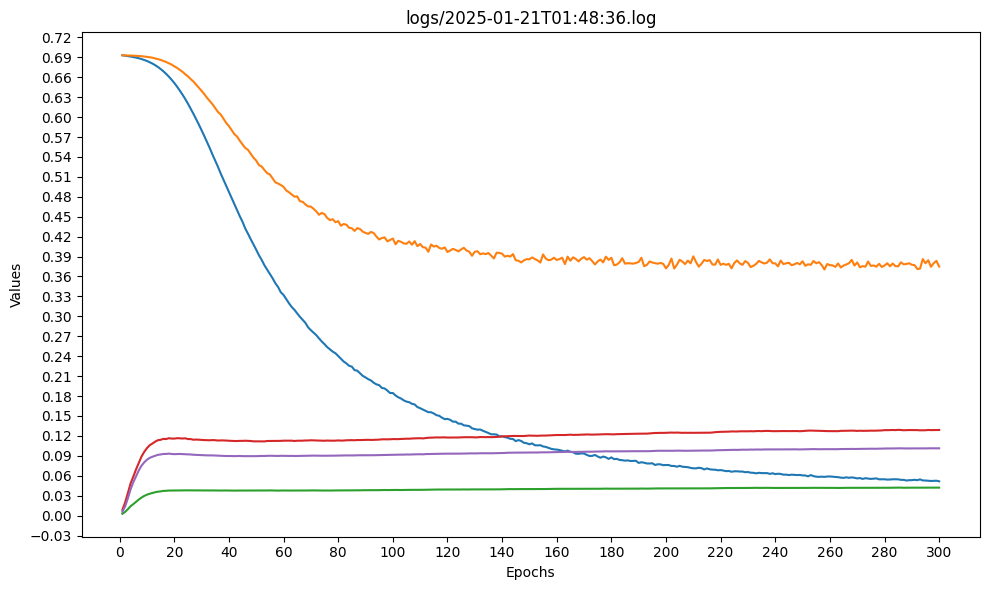

In [384]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, label="T-Loss")
plt.plot(epochs, val_loss, label="V-Loss")

for k in [20]:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
#plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
#plt.xscale("log")

plt.tight_layout()
plt.show()